In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from IPython.display import display

import kornia.augmentation as K
from kornia.geometry.transform import Resize
from kornia.constants import Resample
from PIL import Image
import cv2
import torchvision.transforms.functional as TF
from tqdm import tqdm
import tqdm as notebook_tqdm

In [2]:
import os
import sys

# Add root path to sys.path so imports work
sys.path.append(os.path.abspath(os.path.join('..')))


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subirbiswas19/skin-disease-dataset")

print("Path to dataset files:", path)

/home/mcqueen/Documents/SmartHealth-LLM/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1


In [4]:
for root, dirs, files in os.walk(path):
    print("Folder:", root)


Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/train_set
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/train_set/VI-chickenpox
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/train_set/BA-impetigo
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/train_set/PA-cutaneous-larva-migrans
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/1/skin-disease-datasaet/train_set/FU-nail-fungus
Folder: /home/mcqueen/.cache/kagglehub/datasets/subirbiswas19/skin-disease-dataset/versions/

In [5]:
train_data_path = os.path.join(path,"skin-disease-datasaet","train_set")
test_data_path = os.path.join(path,"skin-disease-datasaet","test_set")

In [6]:
train_list_dir = os.listdir(train_data_path)
test_list_dir = os.listdir(test_data_path)

In [7]:
train_list_dir

['VI-chickenpox',
 'BA-impetigo',
 'PA-cutaneous-larva-migrans',
 'FU-nail-fungus',
 'BA- cellulitis',
 'VI-shingles',
 'FU-ringworm',
 'FU-athlete-foot']

In [8]:
label_mapping = {
    'VI-chickenpox': 0,
    'BA-impetigo': 1,
    'PA-cutaneous-larva-migrans': 2,
    'FU-nail-fungus': 3,
    'BA- cellulitis': 4,
    'VI-shingles': 5,
    'FU-ringworm': 6,
    'FU-athlete-foot': 7
}


In [9]:
data_train = []

for disease_name in train_list_dir:
    disease_folder_path = os.path.join(train_data_path, disease_name)
    train_disease_pic_names = os.listdir(disease_folder_path)

    for pic_name in train_disease_pic_names:
        pic_path = os.path.join(disease_folder_path, pic_name)
        data_train.append({"image_path": pic_path, "label": disease_name})

        
df_train = pd.DataFrame(data_train)
df_train["label_values"] = df_train["label"].map(label_mapping)


In [10]:
df_train

,image_path,label,label_values
0,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
1,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
2,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
3,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
4,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
...,...,...,...
920,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
921,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
922,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
923,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7


In [11]:
data_test = []

for disease_name in test_list_dir:
    disease_folder_path = os.path.join(test_data_path, disease_name)
    test_disease_pic_names = os.listdir(disease_folder_path)

    for pic_name in test_disease_pic_names:
        pic_path = os.path.join(disease_folder_path, pic_name)
        data_test.append({"image_path": pic_path, "label": disease_name})
        
df_test = pd.DataFrame(data_test)
df_test["label_values"] = df_test["label"].map(label_mapping)

In [12]:
df_test

,image_path,label,label_values
0,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
1,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
2,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
3,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
4,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
...,...,...,...
229,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
230,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
231,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
232,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7


                      Disease  count
0               VI-chickenpox    136
1              BA- cellulitis    136
2                 VI-shingles    130
3              FU-nail-fungus    129
4             FU-athlete-foot    124
5  PA-cutaneous-larva-migrans    100
6                 FU-ringworm     90
7                 BA-impetigo     80


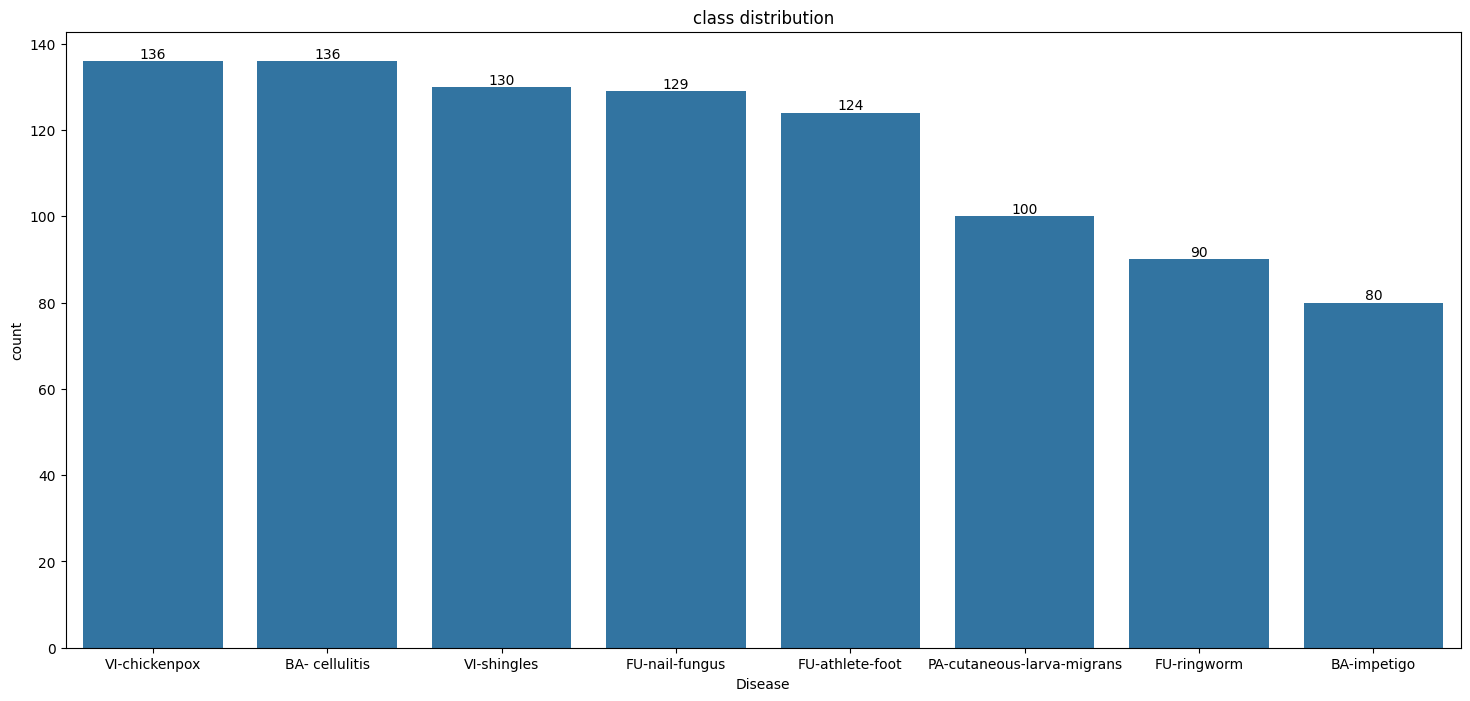

In [13]:
label_counts =  df_train["label"].value_counts().reset_index()
label_counts.columns = ["Disease", "count"]
print(label_counts)
plt.figure(figsize=(18,8))
ax = sns.barplot(x=  "Disease", y = "count", data = label_counts)
plt.title("class distribution")
ax.bar_label(ax.containers[0])
plt.show()


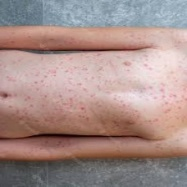

In [14]:
from PIL import Image

image = Image.open(df_train["image_path"].iloc[0])
image_array = np.array(image)

display(image)

In [15]:
import cv2

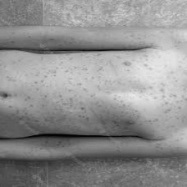

In [16]:
gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
display(Image.fromarray(gray))


In [17]:
import numpy as np

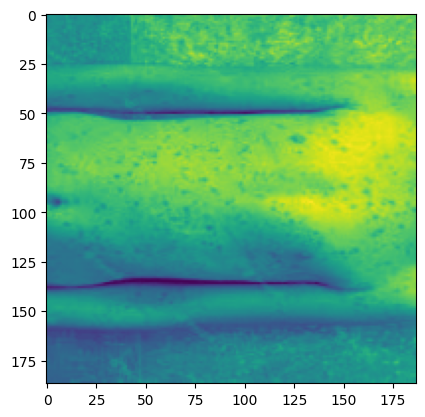

In [18]:
norm_image = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
plt.imshow(norm_image)

In [19]:
from albumentations import Resize , Compose, Normalize, HorizontalFlip, GridDistortion, RandomBrightnessContrast, ToGray

train_agumentation = Compose([
    Resize(64, 64),
    
    Normalize()

])

unbalanced_transform = Compose([
    Resize(64, 64),
    HorizontalFlip(p=0.4),
    GridDistortion(p=0.6),
    RandomBrightnessContrast(p=0.5),
    Normalize()

])

test_agumentation = Compose([
    Resize(64, 64),
    Normalize()
])

In [20]:
label_counts

,Disease,count
0,VI-chickenpox,136
1,BA- cellulitis,136
2,VI-shingles,130
3,FU-nail-fungus,129
4,FU-athlete-foot,124
5,PA-cutaneous-larva-migrans,100
6,FU-ringworm,90
7,BA-impetigo,80


In [21]:
x_train = []
y_train = []

x_test = []
y_test = []

# Count current samples for each class in df_train
class_counts = df_train["label_values"].value_counts().to_dict()

# Find max samples among all classes (target balance count)
target_count = max(class_counts.values())

# Track how many extra we’ve added for each class
counter = {i: 0 for i in class_counts.keys()}

# First pass — add original images (augmented once)
for idx, row in df_train.iterrows():
    img_path = row["image_path"]
    label = row["label_values"]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_aug = train_agumentation(image=img)['image']
    x_train.append(img_aug.flatten())
    y_train.append(label)

# Second pass — oversample until balanced
for label in class_counts.keys():
    while counter[label] + class_counts[label] < target_count:
        # Randomly pick an image from this class
        sample_row = df_train[df_train["label_values"] == label].sample(1).iloc[0]
        img = cv2.imread(sample_row["image_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_aug = unbalanced_transform(image=img)['image']  # stronger augmentations
        x_train.append(img_aug.flatten())
        y_train.append(label)
        counter[label] += 1

# Test set stays the same
for idx, row in df_test.iterrows():
    img_path = row["image_path"]
    label = row["label_values"]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = test_agumentation(image=img)['image']
    x_test.append(img.flatten())
    y_test.append(label)


In [22]:
len(x_train), len(y_train), len(x_test), len(y_test)

(1088, 1088, 234, 234)

In [23]:
x_train ,  x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [24]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1088, 12288), (1088,), (234, 12288), (234,))

In [25]:
import numpy as np

unique_vals, counts = np.unique(y_train, return_counts=True)

print("Class distribution:")
for val, count in zip(unique_vals, counts):
    print(f"Class {val}: {count} samples")


Class distribution:
Class 0: 136 samples
Class 1: 136 samples
Class 2: 136 samples
Class 3: 136 samples
Class 4: 136 samples
Class 5: 136 samples
Class 6: 136 samples
Class 7: 136 samples


In [27]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
lgbm = LGBMClassifier(n_estimators=50, max_depth=5, force_col_wise=True)

lgbm.fit(x_train, y_train)
preds = lgbm.predict(x_test)


[LightGBM] [Info] Total Bins 2178802
[LightGBM] [Info] Number of data points in the train set: 1088, number of used features: 12288
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/home/mcqueen/Documents/SmartHealth-LLM/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [32]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        34
           1       0.62      0.80      0.70        20
           2       0.68      0.76      0.72        25
           3       0.61      0.61      0.61        33
           4       0.76      0.65      0.70        34
           5       0.74      0.79      0.76        33
           6       0.74      0.74      0.74        23
           7       0.91      0.62      0.74        32

    accuracy                           0.74       234
   macro avg       0.74      0.74      0.73       234
weighted avg       0.74      0.74      0.73       234



In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [34]:
dtc = DecisionTreeClassifier()
dtc_param_grids = {
    "criterion" :["gini", "entropy", "log_loss"]
}
dtc_GSCV = GridSearchCV(dtc,  dtc_param_grids, cv = 10, scoring = "accuracy", verbose = 3)
dtc_GSCV.fit(x_train, y_train)
print(f"best params {dtc_GSCV.best_params_}")
print(f"best score : {dtc_GSCV.best_score_}")

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END ...................criterion=gini;, score=0.486 total time=   7.4s
[CV 2/10] END ...................criterion=gini;, score=0.505 total time=   6.6s
[CV 3/10] END ...................criterion=gini;, score=0.569 total time=   7.1s
[CV 4/10] END ...................criterion=gini;, score=0.486 total time=   6.6s
[CV 5/10] END ...................criterion=gini;, score=0.523 total time=   7.0s
[CV 6/10] END ...................criterion=gini;, score=0.532 total time=   6.7s
[CV 7/10] END ...................criterion=gini;, score=0.514 total time=   6.8s
[CV 8/10] END ...................criterion=gini;, score=0.477 total time=   7.3s
[CV 9/10] END ...................criterion=gini;, score=0.380 total time=   6.6s
[CV 10/10] END ..................criterion=gini;, score=0.472 total time=   6.6s
[CV 1/10] END ................criterion=entropy;, score=0.486 total time=   9.7s
[CV 2/10] END ................criterion=entropy;

In [332]:
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78        34
           1       0.52      0.55      0.54        20
           2       0.71      0.60      0.65        25
           3       0.45      0.39      0.42        33
           4       0.65      0.59      0.62        34
           5       0.51      0.61      0.56        33
           6       0.44      0.52      0.48        23
           7       0.54      0.44      0.48        32

    accuracy                           0.57       234
   macro avg       0.57      0.57      0.57       234
weighted avg       0.57      0.57      0.57       234



In [334]:
print(confusion_matrix(y_test, dtc_pred))

[[29  0  0  1  0  1  2  1]
 [ 2 11  0  2  1  2  1  1]
 [ 1  1 15  2  2  1  1  2]
 [ 1  3  1 13  4  7  1  3]
 [ 1  3  3  1 20  3  3  0]
 [ 1  1  0  4  2 20  2  3]
 [ 1  0  1  3  1  3 12  2]
 [ 4  2  1  3  1  2  5 14]]


In [35]:
from sklearn.ensemble import RandomForestClassifier


In [36]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_pred = rfc.predict(x_test)

In [37]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        34
           1       0.58      0.75      0.65        20
           2       0.65      0.88      0.75        25
           3       0.72      0.64      0.68        33
           4       0.79      0.68      0.73        34
           5       0.79      0.82      0.81        33
           6       0.74      0.61      0.67        23
           7       0.92      0.72      0.81        32

    accuracy                           0.76       234
   macro avg       0.75      0.75      0.75       234
weighted avg       0.77      0.76      0.76       234



In [38]:
print(confusion_matrix(y_test, rfc_pred))

[[32  1  0  1  0  0  0  0]
 [ 2 15  0  0  0  0  3  0]
 [ 0  0 22  0  1  1  0  1]
 [ 1  0  4 21  4  1  1  1]
 [ 1  1  4  3 23  2  0  0]
 [ 0  1  0  3  1 27  1  0]
 [ 1  4  2  1  0  1 14  0]
 [ 1  4  2  0  0  2  0 23]]


In [30]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = { "n_neighbors" : range(1, 21), "weights": ['uniform', 'distance'], "algorithm" :['auto', 'ball_tree', 'kd_tree', 'brute'],
             "p" :[1, 2]}
knn = KNeighborsClassifier()

GSCV_scores = GridSearchCV(knn, param_grid, cv = 10, scoring = "accuracy", verbose= 3)
GSCV_scores.fit(x_train, y_train)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
[CV 1/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.633 total time=   1.4s
[CV 2/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.752 total time=   1.4s
[CV 3/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.734 total time=   1.4s
[CV 4/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.743 total time=   1.4s
[CV 5/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.725 total time=   1.3s
[CV 6/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.697 total time=   1.3s
[CV 7/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.587 total time=   1.3s
[CV 8/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.679 total time=   1.3s
[CV 9/10] END algorithm=auto, n_neighbors=1, p=1, weights=uniform;, score=0.639 total time=   1.3s
[CV 10/10] END algorithm=auto, n_neighbors=1

,estimator,KNeighborsClassifier()
,param_grid,"{'algorithm': ['auto', 'ball_tree', ...], 'n_neighbors': range(1, 21), 'p': [1, 2], 'weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,1


In [31]:
GSCV_scores.best_params_

{'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

In [32]:
GSCV_scores.best_score_

np.float64(0.6911569826707441)

In [39]:
from sklearn.svm import SVC

In [40]:
svc = SVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)

In [41]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89        34
           1       0.50      0.50      0.50        20
           2       0.47      0.60      0.53        25
           3       0.65      0.73      0.69        33
           4       0.70      0.68      0.69        34
           5       0.73      0.67      0.70        33
           6       0.52      0.57      0.54        23
           7       0.90      0.59      0.72        32

    accuracy                           0.67       234
   macro avg       0.67      0.66      0.66       234
weighted avg       0.69      0.67      0.67       234



In [42]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()

In [43]:
GNB.fit(x_train, y_train)
GNB_pred = GNB.predict(x_test)

In [44]:
print(classification_report(y_test, GNB_pred))

              precision    recall  f1-score   support

           0       0.45      0.44      0.45        34
           1       0.12      0.15      0.13        20
           2       0.26      0.40      0.32        25
           3       0.51      0.55      0.53        33
           4       0.29      0.21      0.24        34
           5       0.15      0.12      0.14        33
           6       0.23      0.43      0.30        23
           7       0.44      0.12      0.20        32

    accuracy                           0.30       234
   macro avg       0.31      0.30      0.29       234
weighted avg       0.32      0.30      0.30       234



In [45]:
print(confusion_matrix(y_test, GNB_pred))

[[15  5  6  2  1  2  3  0]
 [ 1  3  0  0  2  3 10  1]
 [ 2  3 10  1  6  3  0  0]
 [ 4  0  3 18  4  2  0  2]
 [ 2  1  8  7  7  6  2  1]
 [ 3  4  2  3  2  4 15  0]
 [ 2  4  3  0  0  3 10  1]
 [ 4  6  6  4  2  3  3  4]]


In [288]:
import cv2
import numpy as np

def image_preprocessing(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Check if image is loaded properly
    if img is None:
        raise ValueError(f"Image not found or unreadable: {image_path}")

    # Resize image to 64x64
    img = cv2.resize(img, (64, 64))

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Flatten the image to a 1D array
    return img.flatten()


In [289]:
df_train = df_train.sample(frac = 1, random_state=42).reset_index(drop=True)

In [290]:
x_train = []
y_train = []
for idx, row in df_train.iterrows():
    img_path = row["image_path"]
    label = row["label_values"]
    x_train.append(image_preprocessing(img_path))
    y_train.append(label)

In [291]:
df_test

,image_path,label,label_values
0,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
1,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
2,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
3,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
4,/home/mcqueen/.cache/kagglehub/datasets/subirb...,VI-chickenpox,0
...,...,...,...
229,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
230,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
231,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7
232,/home/mcqueen/.cache/kagglehub/datasets/subirb...,FU-athlete-foot,7


In [292]:
x_test = []
y_test = []
for idx, row in df_test.iterrows():
    img_path = row["image_path"]
    label = row["label_values"]
    x_test.append(image_preprocessing(img_path))
    y_test.append(label)

In [293]:
x_train ,  x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [294]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((925, 4096), (925,), (234, 4096), (234,))

In [296]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [297]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc_pred = dtc.predict(x_test)


In [299]:
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

           0       0.65      0.82      0.73        34
           1       0.28      0.25      0.26        20
           2       0.68      0.52      0.59        25
           3       0.48      0.39      0.43        33
           4       0.53      0.56      0.54        34
           5       0.49      0.64      0.55        33
           6       0.32      0.35      0.33        23
           7       0.65      0.47      0.55        32

    accuracy                           0.52       234
   macro avg       0.51      0.50      0.50       234
weighted avg       0.53      0.52      0.52       234



In [176]:
from albumentations import Compose, Resize, HorizontalFlip, Normalize, GridDistortion, GaussNoise,  VerticalFlip, Rotate, ToTensorV2, RGBShift

train_transform = Compose([
    Resize(256, 256),
    HorizontalFlip(p=0.5),
    Rotate(p=0.1),
    VerticalFlip(p=0.5),
    GridDistortion(p=0.2),
    Normalize(),
    ToTensorV2()

])

unbalanced_transform = Compose([
        Resize(256, 256),
    HorizontalFlip(p=0.5),
    Rotate(p=0.3),
    GridDistortion(p=0.5),
        GaussNoise( p=0.5),

    VerticalFlip(p=0.6),
    Normalize(),
    ToTensorV2()


])

test_tranform = Compose([
    Resize(256, 256),
    Normalize(),
    ToTensorV2()
])


In [177]:
from torch.utils.data import Dataset


class DataAgumentation(Dataset):
    def __init__(self, df : pd.DataFrame, train_transform, unbalanced_transform, test_tranform, specialClasses : list, unbalancedAgumentCount : int, mode: str):
        self.df = df.reset_index(drop = True)
        self.train_transform = train_transform
        self.unbalanced_transform = unbalanced_transform
        self.test_transform = test_tranform
        self.specialclasses = specialClasses
        self.unbalancedAgumentCount = unbalancedAgumentCount
        self.counter = {i:0 for i in specialClasses }
        self.mode = mode

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = row["label_values"]

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.mode == "train":
            if label in self.specialclasses and self.counter[label] < self.unbalancedAgumentCount:
                image = self.unbalanced_transform(image=image)['image']
                self.counter[label] += 1
            else:
                image = self.train_transform(image=image)['image']
        elif self.mode == "test":
            image = self.test_transform(image=image)['image']
        else:
            raise ValueError(f"Invalid mode: {self.mode}")

        return image, label






In [178]:
from torch.utils.data import DataLoader

In [179]:
label_counts

,Disease,count
0,VI-chickenpox,136
1,BA- cellulitis,136
2,VI-shingles,130
3,FU-nail-fungus,129
4,FU-athlete-foot,124
5,PA-cutaneous-larva-migrans,100
6,FU-ringworm,90
7,BA-impetigo,80


In [180]:
train_dataset= DataAgumentation(df= df_train,  train_transform=train_transform, unbalanced_transform=unbalanced_transform, test_tranform=test_tranform, specialClasses=[6, 7], unbalancedAgumentCount=  50, mode= "train")
test_dataset= DataAgumentation(df= df_test,  train_transform=train_transform, unbalanced_transform=unbalanced_transform, test_tranform=test_tranform, specialClasses=[6, 7], unbalancedAgumentCount=  50, mode= "test")

In [181]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [185]:
images, labels = next(iter(test_loader))
print(images.shape)   # e.g., torch.Size([32, 3, 224, 224])
print(labels.shape)   # e.g., torch.Size([32])


torch.Size([32, 3, 256, 256])
torch.Size([32])


In [186]:
images, labels = next(iter(train_loader))
print(images.shape)   # e.g., torch.Size([32, 3, 224, 224])
print(labels.shape)   # e.g., torch.Size([32])


torch.Size([32, 3, 256, 256])
torch.Size([32])


In [188]:
count_tensors = 0
for images, labels in test_loader:
    count_tensors += images.size(0)  # Correct: batch size

print(f"Number of images turned into tensors by DataLoader: {count_tensors}")
print(f"Total images in training dataset: {len(df_train)}")


Number of images turned into tensors by DataLoader: 234
Total images in training dataset: 925


In [ ]:
label_map = {
    "BA- cellulitis" : 0,
    'BA-impetigo':1,
 'FU-athlete-foot':2,
 'FU-nail-fungus':3,
 'FU-ringworm':4,
 'PA-cutaneous-larva-migrans':5,
 'VI-chickenpox':6,
 'VI-shingles':7    
}

In [11]:
df_train["num_label"] = df_train["label"].map(label_map)

In [12]:
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)


In [13]:
df_train

,image_path,label,num_label
0,..\skin-disease-datasaet\train_set\FU-athlete-...,FU-athlete-foot,2
1,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles,7
2,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis,0
3,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles,7
4,..\skin-disease-datasaet\train_set\FU-athlete-...,FU-athlete-foot,2
...,...,...,...
920,..\skin-disease-datasaet\train_set\BA- celluli...,BA- cellulitis,0
921,..\skin-disease-datasaet\train_set\FU-athlete-...,FU-athlete-foot,2
922,..\skin-disease-datasaet\train_set\VI-shingles...,VI-shingles,7
923,..\skin-disease-datasaet\train_set\FU-nail-fun...,FU-nail-fungus,3


In [14]:
df_test["num_label"] = df_test["label"].map(label_map)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)


In [15]:
df_test

,image_path,label,num_label
0,..\skin-disease-datasaet\test_set\FU-athlete-f...,FU-athlete-foot,2
1,..\skin-disease-datasaet\test_set\VI-shingles\...,VI-shingles,7
2,..\skin-disease-datasaet\test_set\VI-chickenpo...,VI-chickenpox,6
3,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis,0
4,..\skin-disease-datasaet\test_set\FU-ringworm\...,FU-ringworm,4
...,...,...,...
229,..\skin-disease-datasaet\test_set\FU-nail-fung...,FU-nail-fungus,3
230,..\skin-disease-datasaet\test_set\BA- cellulit...,BA- cellulitis,0
231,..\skin-disease-datasaet\test_set\FU-nail-fung...,FU-nail-fungus,3
232,..\skin-disease-datasaet\test_set\VI-chickenpo...,VI-chickenpox,6


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch
import kornia.augmentation as K
import kornia.geometry.transform as KG
from tqdm import tqdm

class SkinDataset(Dataset):
    def __init__(self, df, img_size=(224, 224)):
        self.df = df
        self.img_size = img_size
        self.to_tensor = T.ToTensor()
        self.resize = T.Resize(self.img_size)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]
        label = self.df.iloc[idx]['num_label']
        image = Image.open(img_path).convert("RGB")
        image = self.resize(image)
        image = self.to_tensor(image)
        
        # Convert label to tensor (if it's not already)
        label = torch.tensor(label, dtype=torch.long)  # Use torch.float32 for regression
        return image, label

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
kornia_transform = nn.Sequential(
    K.Normalize(mean=torch.tensor([0.485, 0.456, 0.406], device=device),
                std=torch.tensor([0.229, 0.224, 0.225], device=device))
).to(device)

In [19]:
dataset_train = SkinDataset(df_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = SkinDataset(df_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [185]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8):  # Now supports 8 classes
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers (adjust input size if needed)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # Input after conv layers
        self.fc2 = nn.Linear(512, num_classes)    # Output = 8 classes
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Conv + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # Output: (64, 28, 28)
        
        # Flatten for FC layers
        x = x.view(-1, 64 * 28 * 28)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output shape: (batch_size, 8)
        
        return x

In [186]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Initialize
model = SimpleCNN(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader_train):.4f}")

100%|██████████| 29/29 [00:02<00:00, 10.13it/s]


Epoch 1/10, Loss: 2.0613


100%|██████████| 29/29 [00:02<00:00, 11.30it/s]


Epoch 2/10, Loss: 1.7881


100%|██████████| 29/29 [00:02<00:00, 10.58it/s]


Epoch 3/10, Loss: 1.4912


100%|██████████| 29/29 [00:02<00:00, 10.28it/s]


Epoch 4/10, Loss: 1.2585


100%|██████████| 29/29 [00:02<00:00, 11.18it/s]


Epoch 5/10, Loss: 0.9834


100%|██████████| 29/29 [00:02<00:00, 11.17it/s]


Epoch 6/10, Loss: 0.7726


100%|██████████| 29/29 [00:02<00:00, 11.21it/s]


Epoch 7/10, Loss: 0.5140


100%|██████████| 29/29 [00:02<00:00, 11.12it/s]


Epoch 8/10, Loss: 0.4293


100%|██████████| 29/29 [00:02<00:00, 10.90it/s]


Epoch 9/10, Loss: 0.3907


100%|██████████| 29/29 [00:02<00:00, 10.15it/s]

Epoch 10/10, Loss: 0.2211


In [187]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get class index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 76.50%


In [38]:
print(f"Memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
print(f"Memory cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")

Memory allocated: 85.65 MB
Memory cached: 232.00 MB


In [20]:
dataset_train = SkinDataset(df_train)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=8):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Adaptive pooling layer to handle varying input sizes
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=8):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [22]:
# Initialize
import torch.optim as optim

model = ResNet18(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation code remains the same as before

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Initialize
model = ResNet18(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader_train):.4f}")

100%|██████████| 58/58 [09:30<00:00,  9.84s/it]


Epoch 1/10, Loss: 2.0375


100%|██████████| 58/58 [10:46<00:00, 11.15s/it]


Epoch 2/10, Loss: 1.7774


100%|██████████| 58/58 [10:46<00:00, 11.15s/it]


Epoch 3/10, Loss: 1.7719


100%|██████████| 58/58 [10:41<00:00, 11.05s/it]


Epoch 4/10, Loss: 1.6782


100%|██████████| 58/58 [10:48<00:00, 11.18s/it]


Epoch 5/10, Loss: 1.6225


100%|██████████| 58/58 [10:46<00:00, 11.15s/it]


Epoch 6/10, Loss: 1.5810


100%|██████████| 58/58 [10:55<00:00, 11.30s/it]


Epoch 7/10, Loss: 1.5885


100%|██████████| 58/58 [10:34<00:00, 10.94s/it]


Epoch 8/10, Loss: 1.4980


100%|██████████| 58/58 [10:11<00:00, 10.53s/it]


Epoch 9/10, Loss: 1.5006


100%|██████████| 58/58 [10:13<00:00, 10.58s/it]

Epoch 10/10, Loss: 1.5044


In [1]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get class index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 44.87%


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm  # For EfficientNet models


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet
model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify the final classification layer 
model.classifier = nn.Linear(model.classifier.in_features, 8)
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader_train):.4f}")


100%|██████████| 29/29 [01:45<00:00,  3.64s/it]


Epoch [1/10], Loss: 0.6263


100%|██████████| 29/29 [01:21<00:00,  2.83s/it]


Epoch [2/10], Loss: 0.2454


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


Epoch [3/10], Loss: 0.1169


100%|██████████| 29/29 [01:20<00:00,  2.78s/it]


Epoch [4/10], Loss: 0.0683


100%|██████████| 29/29 [01:23<00:00,  2.86s/it]


Epoch [5/10], Loss: 0.0410


 17%|█▋        | 5/29 [00:14<01:10,  2.94s/it]


KeyboardInterrupt: 

In [23]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 94.87%


In [28]:
torch.save(model.state_dict(), "efficientnet_b0_skin_classifier_weights.pth")


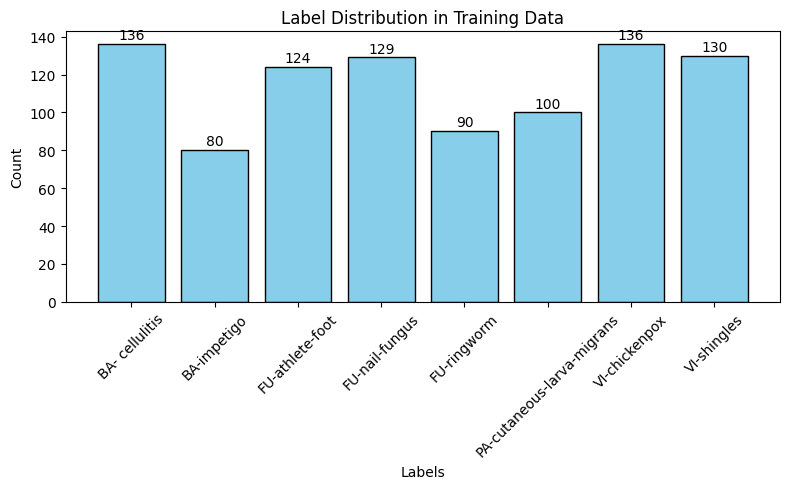

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Count each label
label_counts = df_train["label"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(label_counts.index, label_counts.values, color='skyblue', edgecolor='black')

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, int(yval), ha='center', va='bottom')

plt.title("Label Distribution in Training Data")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
label_counts

label
BA- cellulitis                136
BA-impetigo                    80
FU-athlete-foot               124
FU-nail-fungus                129
FU-ringworm                    90
PA-cutaneous-larva-migrans    100
VI-chickenpox                 136
VI-shingles                   130
Name: count, dtype: int64

In [41]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [88]:
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F

@torch.no_grad()
def load_model(model_path, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = timm.create_model('efficientnet_b0', pretrained=False)
    model.classifier = nn.Linear(model.classifier.in_features, 8)  # 8 classes
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


@torch.no_grad()
def predict(model, image_tensor, class_names=None, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.unsqueeze(0).to(device)  # add batch dim

    output = model(image_tensor)
    probabilities = F.softmax(output, dim=1).squeeze()
    predicted_idx = torch.argmax(probabilities).item()

    if class_names:
        return class_names[predicted_idx], probabilities.cpu().numpy()
    return predicted_idx, probabilities.cpu().numpy()


In [89]:
from PIL import Image
import torchvision.transforms as T
import torch
import torch.nn as nn
import kornia.augmentation as K

class ImagePreprocessor:
    def __init__(self, img_size=(224, 224), device=None):
        self.img_size = img_size
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.base_transform = T.Compose([
            T.Resize(self.img_size),
            T.ToTensor()
        ])

        self.kornia_norm = nn.Sequential(
            K.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406], device=self.device),
                std=torch.tensor([0.229, 0.224, 0.225], device=self.device)
            )
        ).to(self.device)

    def preprocess(self, file) -> torch.Tensor:
        image = Image.open(file).convert("RGB")
        image = self.base_transform(image)
        image = image.to(self.device).unsqueeze(0)
        image = self.kornia_norm(image)
        return image.squeeze(0)  # Return [3, H, W]


In [90]:
from image_preprocessing import ImagePreprocessor

processor = ImagePreprocessor(device=device)
model = load_model("efficientnet_b0_skin_classifier_weights.pth", device=device)

In [91]:
image_tensor = processor.preprocess("skin-disease-datasaet/test_set/VI-chickenpox/14_VI-chickenpox (20).jpg")

In [92]:
image_tensor

tensor([[[ 0.2111,  0.2111,  0.2282,  ...,  0.1426,  0.1254,  0.1083],
         [ 0.2111,  0.2111,  0.2282,  ...,  0.1939,  0.1768,  0.1768],
         [ 0.2111,  0.2111,  0.2282,  ...,  0.2624,  0.2624,  0.2624],
         ...,
         [-0.4397, -0.4226, -0.4054,  ..., -1.1589, -1.5185, -1.5870],
         [-0.4568, -0.4568, -0.4397,  ..., -1.6384, -1.7240, -1.2274],
         [-0.4568, -0.4397, -0.4226,  ..., -1.6042, -1.5528, -0.8678]],

        [[ 0.3978,  0.3978,  0.4153,  ...,  0.3102,  0.2927,  0.2752],
         [ 0.3978,  0.3978,  0.4153,  ...,  0.3627,  0.3452,  0.3452],
         [ 0.3978,  0.3978,  0.4153,  ...,  0.4328,  0.4328,  0.4328],
         ...,
         [-0.3725, -0.3550, -0.3375,  ..., -1.1954, -1.5630, -1.6331],
         [-0.3901, -0.3901, -0.3725,  ..., -1.6856, -1.7731, -1.2829],
         [-0.3901, -0.3725, -0.3550,  ..., -1.6506, -1.6155, -0.9153]],

        [[ 0.4614,  0.4614,  0.4788,  ...,  0.4788,  0.4614,  0.4439],
         [ 0.4614,  0.4614,  0.4788,  ...,  0

In [93]:
label_map = {
    "BA-cellulitis": 0,
    "BA-impetigo": 1,
    "FU-athlete-foot": 2,
    "FU-nail-fungus": 3,
    "FU-ringworm": 4,
    "PA-cutaneous-larva-migrans": 5,
    "VI-chickenpox": 6,
    "VI-shingles": 7
}
idx_to_label = {v: k for k, v in label_map.items()}

In [94]:
idx_to_label

{0: 'BA-cellulitis',
 1: 'BA-impetigo',
 2: 'FU-athlete-foot',
 3: 'FU-nail-fungus',
 4: 'FU-ringworm',
 5: 'PA-cutaneous-larva-migrans',
 6: 'VI-chickenpox',
 7: 'VI-shingles'}

In [95]:

label, probs = predict(model, image_tensor, class_names=idx_to_label, device=device)

In [96]:
print("Predicted label:", label)
print("Probabilities:", probs)

Predicted label: VI-chickenpox
Probabilities: [0.08968432 0.00836672 0.027208   0.04355299 0.02703942 0.10591336
 0.6174882  0.08074704]


In [104]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [105]:

# Paths to your data directories
train_dir = 'skin-disease-datasaet/train_set'
val_dir = 'skin-disease-datasaet/test_set'

In [106]:


# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)


In [107]:

# Load images from directories
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)


Found 924 images belonging to 8 classes.


Found 233 images belonging to 8 classes.


In [108]:

# Model setup using transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)  # 8 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:


# Train the model
model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 609ms/step - accuracy: 0.5476 - loss: 1.3736 - val_accuracy: 0.8069 - val_loss: 0.5506
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 556ms/step - accuracy: 0.8727 - loss: 0.4024 - val_accuracy: 0.8970 - val_loss: 0.3034
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 570ms/step - accuracy: 0.9373 - loss: 0.1982 - val_accuracy: 0.8798 - val_loss: 0.2703
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 600ms/step - accuracy: 0.9382 - loss: 0.1910 - val_accuracy: 0.9056 - val_loss: 0.2602
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 598ms/step - accuracy: 0.9532 - loss: 0.1432 - val_accuracy: 0.9270 - val_loss: 0.2309
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 599ms/step - accuracy: 0.9669 - loss: 0.1213 - val_accuracy: 0.9227 - val_loss: 0.2102
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 574ms/step - accuracy: 0.9795 - loss: 0.0899 - val_accuracy: 0.9185 - val_loss: 0.2367
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 539ms/step - accuracy: 0.9753 - loss: 0.0903 - val_accu

In [110]:
model.save('skin_disease_model_8_classes.h5')

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm
import timm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Paths to your data directories
train_dir = 'skin-disease-datasaet/train_set'
val_dir = 'skin-disease-datasaet/test_set'

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load pretrained EfficientNet
model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 8)  # 8 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Validation / Test loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'skin_disease_efficientnet8.pth')

Epoch 1/10: 100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


Epoch [1/10], Loss: 0.6765


Epoch 2/10: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]


Epoch [2/10], Loss: 0.2036


Epoch 3/10: 100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


Epoch [3/10], Loss: 0.1710


Epoch 4/10: 100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


Epoch [4/10], Loss: 0.1500


Epoch 5/10: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Epoch [5/10], Loss: 0.0751


Epoch 6/10: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]


Epoch [6/10], Loss: 0.0547


Epoch 7/10: 100%|██████████| 29/29 [00:18<00:00,  1.61it/s]


Epoch [7/10], Loss: 0.0658


Epoch 8/10: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]


Epoch [8/10], Loss: 0.0541


Epoch 9/10: 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]


Epoch [9/10], Loss: 0.0825


Epoch 10/10: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]


Epoch [10/10], Loss: 0.0872
Test Accuracy: 93.16%
